<a href="https://colab.research.google.com/github/Jawakar-7/CarDheko-Price-Prediction/blob/main/Artefact_removal_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dataset
Instead of Downloading and uploading the dataset we are mounting data from kaggle and extracting using Kaggle API

In [ ]:
! git clone https://github.com/Jawakar-7/Upscalepics-Artefact-remover-using-GAN-s.git
! mkdir ~/.kaggle
! cp /content/Upscalepics-Artefact-remover-using-GAN-s/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d joe1995/div2k-dataset

Cloning into 'Upscalepics-Artefact-remover-using-GAN-s'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 11), reused 12 (delta 3), pack-reused 0
Receiving objects: 100% (30/30), 1.23 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (11/11), done.
100% 3.70G/3.71G [00:31<00:00, 81.2MB/s]
100% 3.71G/3.71G [00:31<00:00, 127MB/s] 


In [ ]:
import zipfile
path= '/content/div2k-dataset.zip'  #  path to  zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  #extraction path


JPEG artifacts : JPEG artifacts are minor defects when an image is saved in . JPG format. Although they are usually not noticeable, they can occasionally be visible as small blotches or decreased image quality. ‍ Several factors, including low-quality JPEG compression, poor lighting conditions, and a camera shake, can cause them.

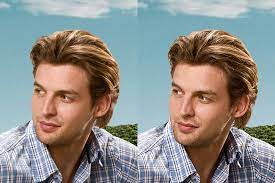

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image=cv2.imread('/content/Upscalepics-Artefact-remover-using-GAN-s/Jpeg_artifact.jpeg')
# cv2.resize(image,(300,300))
cv2_imshow(image)

### Generative Adversial networks
Generative Adversarial Networks are used to generate images that never existed before. They learn about the world (objects, animals and so forth) and create new versions of those images that never existed.

They have two components:

A Generator - this creates the images.
A Discriminator - this assesses the images and tells the generator if they are similar to what it has been trained on. These are based off real world examples.
When training the network, both the generator and discriminator start from scratch and learn together.



In [ ]:
# importing required packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


#Dataset Importing and preparation

In [ ]:
train_gen=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range= 0.1,
    fill_mode='nearest',
)

In [ ]:
#img_size=()
train_ds=train_gen.flow_from_directory('/content/data/DIV2K_train_HR',
                                       color_mode='rgb',
                                       class_mode=None,
                                       keep_aspect_ratio=True,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=True,
                                      # save_to_dir='/content/Upscalepics-Artefact-remover-using-GAN-s/prepro_train'
                                       )


Found 800 images belonging to 1 classes.


## Creating Artifacts
Now that we have created a function to extract images from a image , we are now making it distorted my addinf jpeg atifacts .

In [ ]:
def crearti(train_ds_iterator,image_quality):

  for batch in train_ds_iterator:

    compressed_batch=[]
    for image in batch:
            image_pil = Image.fromarray((image * 255).astype('uint8'))
            compressed_image_pil = Image.new('RGB', image_pil.size)
            compressed_image_pil.paste(image_pil)
            compressed_image_pil.save('temp_compressed.jpg', format='JPEG', quality=jpeg_quality)
            compressed_image = np.array(Image.open('temp_compressed.jpg')) / 255.0
            compressed_batch.append(compressed_image)

    yield np.array(compressed_batch)

jpeg_quality = 50
compressed_train_ds= crearti(train_ds, jpeg_quality)

## Model Creation
Now that i have created a dataset which can be iterated through a GAN Model we should start preparing a model which will upscale the images

###SRGANS:
Here We will be using Super Resolution GAN's to Upscale the images .
I has a  Specific architecture that is mentioned in the below images .


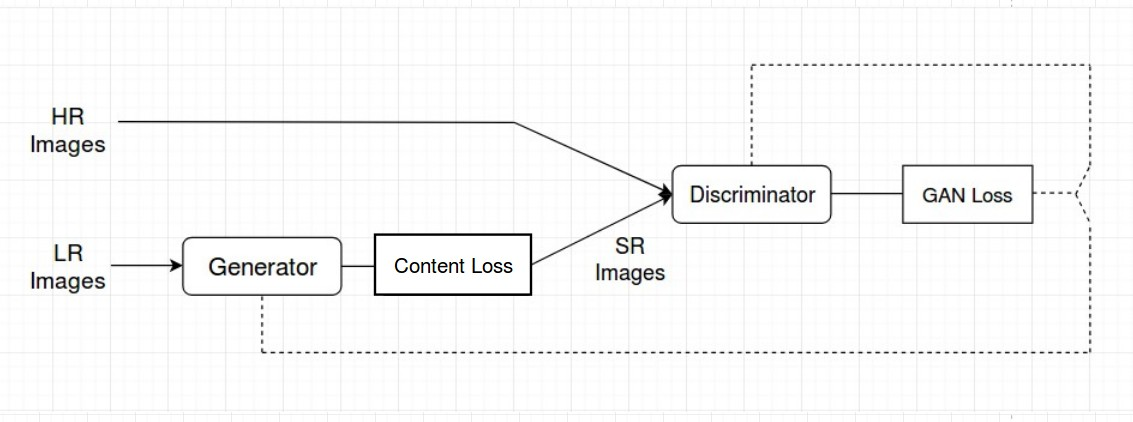

In [ ]:
arc=cv2.imread('/content/Upscalepics-Artefact-remover-using-GAN-s/architecture.jpg')
cv2_imshow(arc)

The Network arhitecture of SRGAN's consists of two models , A Generator and a Discriminator which is basically CNN's and will be using residual methods similar to ResNet's.

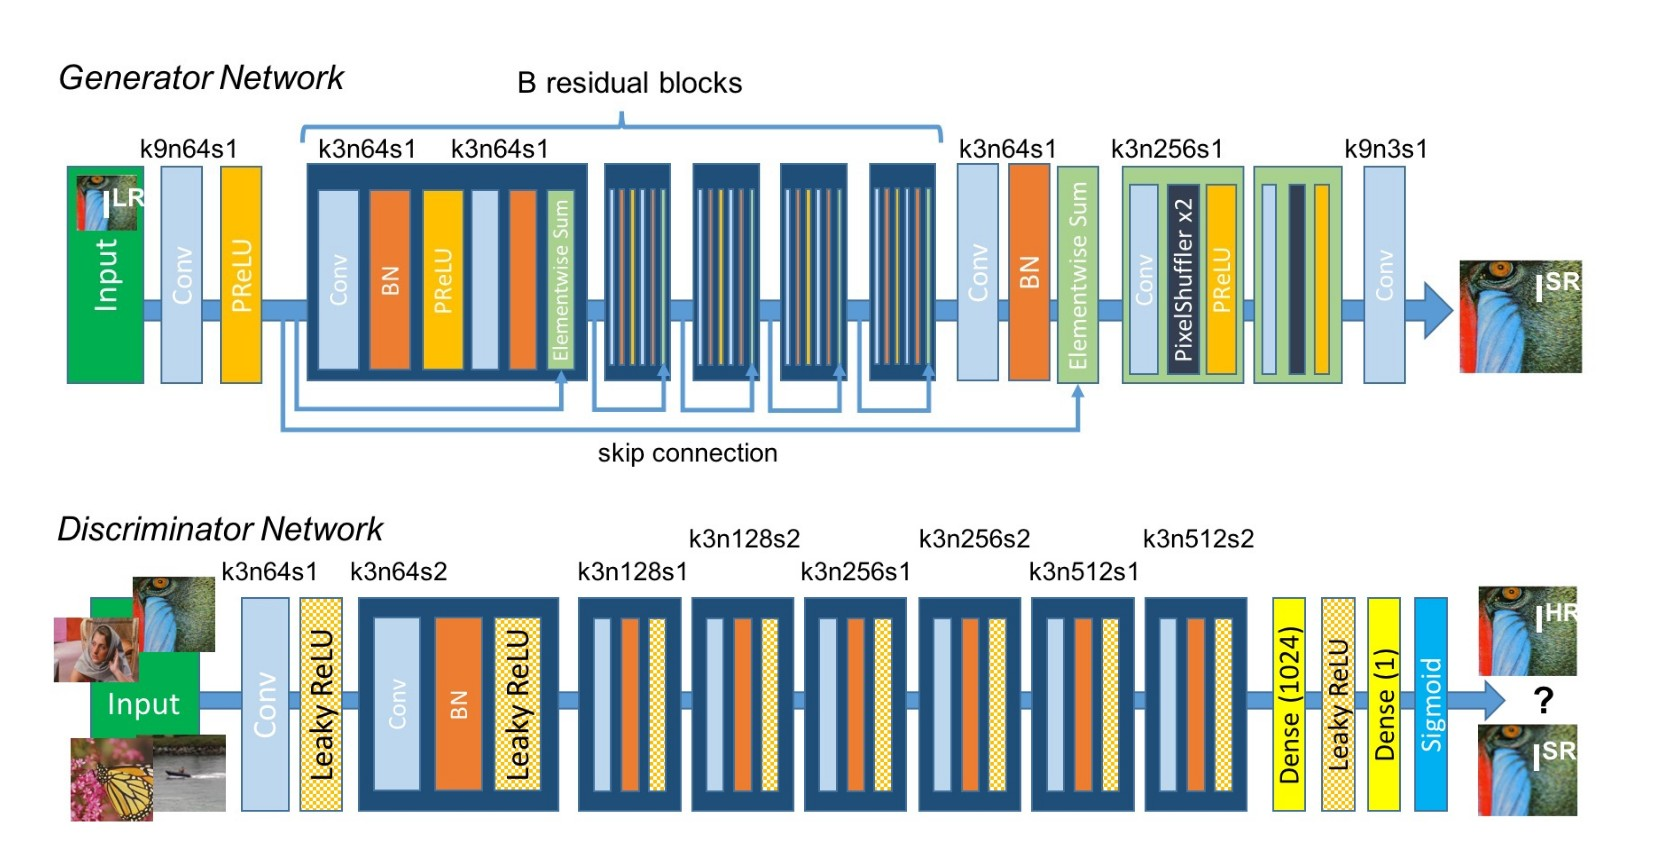

In [ ]:
img=cv2.imread('/content/Upscalepics-Artefact-remover-using-GAN-s/network.jpg')
cv2_imshow(img)



*   In the above network architecture 'K3n64s1' means Convolutional layers of kernel '3*3', with '64' neurons of '1' stride.
*   PReLU - Peaky ReLU or Leaky RELU is the activation functions we will be using in the residual units .
* PixelShuffler is used to upscale the images .









---



Now that we have the data and have defined the loss function(not yet) we will define the GAN Model now

### Importing libraries and functions

In [ ]:
from keras.models import Model
from keras import layers
from keras.layers import add, Activation,Dropout, Dense ,Flatten , BatchNormalization,LeakyReLU , PReLU , Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization

In [ ]:
# Defining Residual Layers for generator
def res_blk(model , kernal_size,filters,strides):
  gen=model
  model=Conv2D(filters=filters,kernel_size=kernal_size,strides=strides,padding="same")(model)
  model=BatchNormalization(momentum=0.5)(model)

  model=PReLU(alpha_initializer='zeros',alpha_regularizer=None,alpha_constraint=None,shared_axes=[1,2])(model)
  model=Conv2D(filters=filters,kernel_size=kernal_size,strides=strides,padding="same")(model)
  model=BatchNormalization(momentum=0.5)(model)

  model=add([gen,model])

  return model

In [ ]:
from keras.layers.reshaping.up_sampling1d import UpSampling1D
#upsamplingblock for generator
#the upscale2d from keras is used to increase spatial values of the data
#one can also use conv2DTranspose to do the same upscaling
# Unlike UpSampling2D, the Conv2DTranspose layer introduces learnable parameters
# (weights) that allow the model to learn an upsampling strategy specific to the
# task at hand. This makes it more flexible and powerful for certain applications,
# but it also increases the number of trainable parameters in the model.
def upscale_block(model,kernel_size,filters,strides):
  model=Conv2D(filters=filters,kernel_size-kernel_size,filters=filters,strides=strides,padding='same')(model)
  model=UpSampling1D(size=2)(model)
  model=LeakyRelu(alpha=0.2)(model)

  return model

In [ ]:
#defining convolutional layers for Discriminator model
def disc_layers(model,filters,kernel_size,strides):
  model=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(model)
  model=BatchNormalization(momentum=0.5)(model)
  model=LeakyRelu(alpha=0.2)(model)

  return model